In [13]:
!pip3 install http://download.pytorch.org/whl/cu92/torch-0.4.1-cp36-cp36m-linux_x86_64.whl
!pip3 install torchvision
!pip3 install GPy
import GPy
import time
import copy
import math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Optimizer
from torch.optim.sgd import SGD

from torchvision import datasets, transforms
from torchvision.utils import make_grid
from tqdm import tqdm, trange
from google.colab import files
%config InlineBackend.figure_format = 'svg'

In [14]:
torch.cuda.device(0)
torch.cuda.get_device_name(torch.cuda.current_device())

'Tesla T4'

In [0]:
def to_variable(var=(), cuda=True, volatile=False):
    out = []
    for v in var:
        
        if isinstance(v, np.ndarray):
            v = torch.from_numpy(v).type(torch.FloatTensor)

        if not v.is_cuda and cuda:
            v = v.cuda()

        if not isinstance(v, Variable):
            v = Variable(v, volatile=volatile)

        out.append(v)
    return out

In [0]:
def log_gaussian_loss(output, target, sigma, no_dim):
    exponent = -0.5*(target - output)**2/sigma**2
    log_coeff = -no_dim*torch.log(sigma)
    
    return - (log_coeff + exponent).sum()


def get_kl_divergence(weights, prior, varpost):
    prior_loglik = prior.loglik(weights)
    
    varpost_loglik = varpost.loglik(weights)
    varpost_lik = varpost_loglik.exp()
    
    return (varpost_lik*(varpost_loglik - prior_loglik)).sum()


class gaussian:
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
        
    def loglik(self, weights):
        exponent = -0.5*(weights - self.mu)**2/self.sigma**2
        log_coeff = -0.5*(np.log(2*np.pi) + 2*np.log(self.sigma))
        
        return (exponent + log_coeff).sum()

In [0]:
class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output, init_log_noise, learn_rate):
        super(Net, self).__init__()
        self.hidden1 = torch.nn.Linear(n_feature, n_hidden)
        self.predict = torch.nn.Linear(n_hidden, n_output)
        self.log_noise = nn.Parameter(torch.cuda.FloatTensor([init_log_noise]))
        
        self.loss_func = log_gaussian_loss
        self.optimizer = torch.optim.SGD(self.parameters(), lr = learn_rate, weight_decay = 0)
        
    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = self.predict(x)
        return x
    
    def fit(self, x, y):
        x, y = to_variable(var=(x, y), cuda=True)
        
        # reset gradient and total loss
        self.optimizer.zero_grad()
        
        output = self.forward(x)
        loss = self.loss_func(output, y, self.log_noise.exp(), 1)
        for param in self.hidden1.parameters(): loss += 0.5*(param**2).sum()
        loss = loss/x.shape[0]
        
        loss.backward()
        self.optimizer.step()

        return loss

In [18]:
np.random.seed(2)
no_points = 400
lengthscale = 1
variance = 1.0
sig_noise = 0.3
x = np.random.uniform(-3, 3, no_points)[:, None]
x.sort(axis = 0)


k = GPy.kern.RBF(input_dim = 1, variance = variance, lengthscale = lengthscale)
C = k.K(x, x) + np.eye(no_points)*sig_noise**2

y = np.random.multivariate_normal(np.zeros((no_points)), C)[:, None]
y = (y - y.mean())
x_train = x[75:325]
y_train = y[75:325]

x_mean, x_std = x_train.mean(), x_train.var()**0.5
y_mean, y_std = y_train.mean(), y_train.var()**0.5

x_train = (x_train - x_mean)/x_std
y_train = (y_train - y_mean)/y_std


nb_epochs, batch_size, nb_train = 1000, len(x_train), len(x_train)

fit_loss_train = np.zeros(nb_epochs)
best_net, best_loss = None, float('inf')
no_nets, nets, losses = 10, [], []

for n in range(no_nets):
    net = Net(n_feature=1, n_hidden=200, n_output=1, init_log_noise=0, learn_rate=1e-2).cuda()
    
    sub_idx = np.random.choice(np.arange(0, len(x_train)), size = (int(len(x_train)*0.8),), replace=True)
    x_train_sub, y_train_sub = x_train[sub_idx], y_train[sub_idx]
    
    for i in range(nb_epochs):

        loss = net.fit(x_train_sub, y_train_sub)

        if i % 100 == 0:
            print('Epoch %d' % i, loss.cpu().data.numpy(), torch.exp(net.log_noise).cpu().data.numpy())
            
    nets.append(copy.deepcopy(net))
    

Epoch 0 1.0049833 [1.0040159]
Epoch 100 0.060154855 [0.5954132]
Epoch 200 14.184133 [0.59919554]
Epoch 300 0.24480693 [0.8576353]
Epoch 400 -0.52866566 [0.37393752]
Epoch 500 -0.47787154 [0.40755075]
Epoch 600 -0.47490203 [0.41380826]
Epoch 700 -0.41914618 [0.4492629]
Epoch 800 -0.40289947 [0.46263954]
Epoch 900 -0.3374153 [0.50529504]
Epoch 0 0.70751053 [0.99758744]
Epoch 100 -0.0031776237 [0.56398565]
Epoch 200 -0.020823516 [0.6670902]
Epoch 300 -0.105920754 [0.61797976]
Epoch 400 -0.0569145 [0.6584197]
Epoch 500 -0.012299709 [0.69591707]
Epoch 600 4.873294 [0.36652088]
Epoch 700 -0.0149441715 [0.6714553]
Epoch 800 -0.6897275 [0.3066578]
Epoch 900 -0.6668208 [0.321763]
Epoch 0 0.77746433 [0.9987278]
Epoch 100 -0.00709919 [0.5599126]
Epoch 200 -0.057044256 [0.6313224]
Epoch 300 0.085026145 [0.7507361]
Epoch 400 -0.5814239 [0.33509257]
Epoch 500 -0.5787069 [0.34140405]
Epoch 600 -0.56419355 [0.35324836]
Epoch 700 -0.58136296 [0.348402]
Epoch 800 -0.5886372 [0.34857824]
Epoch 900 -0.563

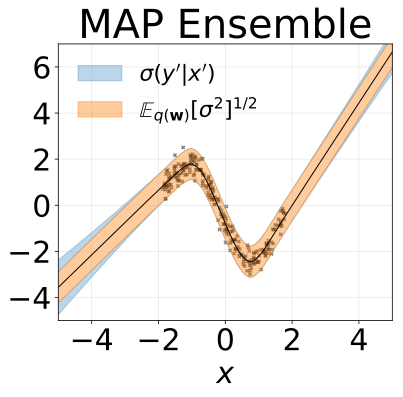

In [19]:
values, noises = [], []
for net in nets:
    values.append((net(torch.linspace(-5, 5, 200)[:, None].cuda()).cpu().data.numpy()* y_std) + y_mean)
    noises.append(net.log_noise.exp().cpu().data.numpy() * y_std)
      
values = np.array(values).reshape(no_nets, 200)
means, epistemic = values.mean(axis = 0), values.var(axis = 0)**0.5
noises = np.array(noises)
aleatoric = (noises**2).mean()**0.5

total_unc = (aleatoric**2 + epistemic**2)**0.5

c = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
     '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

plt.figure(figsize = (6, 5))
plt.style.use('default')
plt.scatter(x_train*x_std + x_mean, y_train*y_std + y_mean, s = 10, marker = 'x', color = 'black', alpha = 0.5)
plt.fill_between(np.linspace(-5, 5, 200)*x_std + x_mean, means + aleatoric, means + total_unc, color = c[0], alpha = 0.3, label = r"$\sigma(y'|x')$")
plt.fill_between(np.linspace(-5, 5, 200)*x_std + x_mean, means - total_unc, means - aleatoric, color = c[0], alpha = 0.3)
plt.fill_between(np.linspace(-5, 5, 200)*x_std + x_mean, means - aleatoric, means + aleatoric, color = c[1], alpha = 0.4, label = r'$\mathbb{E}_{q(\mathbf{w})}[\sigma^2]^{1/2}$')
plt.plot(np.linspace(-5, 5, 200)*x_std + x_mean, means, color = 'black', linewidth = 1)
plt.xlim([-5, 5])
plt.ylim([-5, 7])
plt.xlabel('$x$', fontsize=30)
plt.title('MAP Ensemble', fontsize=40)
plt.tick_params(labelsize=30)
plt.xticks(np.arange(-4, 5, 2))
plt.yticks(np.arange(-4, 7, 2))
plt.gca().yaxis.grid(alpha=0.3)
plt.gca().xaxis.grid(alpha=0.3)
plt.legend(loc = 2, fontsize = 22, frameon=False)
plt.savefig('map_homo.pdf', bbox_inches = 'tight')

files.download("map_homo.pdf")

plt.show()